<a href="https://colab.research.google.com/github/AlephEleven/Fruit-Checker/blob/main/Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Load Kaggle API (Enter kaggle API key) { display-mode: "form" }
!pip install -q kaggle

from google.colab import files

files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#@title Download Fruits Dataset { vertical-output: true }
!kaggle datasets download sshikamaru/fruit-recognition
!unzip fruit-recognition.zip -d fruit-dataset

Streaming output truncated to the last 5000 lines.
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_264.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_265.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_266.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_267.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_268.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_269.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_27.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_270.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_271.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_272.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_273.jpg  
  inflating: fruit-dataset/train/train/Pepper Green/Pepper Green_274.jpg  
  inflating: fruit-dataset/train/train/Pepper Gree

In [3]:
#total test files
!ls -1 fruit-dataset/test/test | wc -l

#total fruit types
!ls -1 fruit-dataset/train/train | wc -l

#total train files
!ls -lR fruit-dataset/train/train | grep "^-" | wc -l

5641
33
16854


In [4]:
!ls fruit-dataset/train/train

'Apple Braeburn'       Clementine       Orange		 Pomegranate
'Apple Granny Smith'   Corn	        Papaya		'Potato Red'
 Apricot	      'Cucumber Ripe'  'Passion Fruit'	 Raspberry
 Avocado	      'Grape Blue'      Peach		 Strawberry
 Banana		       Kiwi	        Pear		 Tomato
 Blueberry	       Lemon	       'Pepper Green'	 Watermelon
'Cactus fruit'	       Limes	       'Pepper Red'
 Cantaloupe	       Mango	        Pineapple
 Cherry		      'Onion White'     Plum


In [5]:
#@title Combine Dataset to Single Folder
sh = """
#!/bin/bash

# change to the parent directory
cd fruit-dataset/train/train

for d in */ ; do for f in "$d"/* ; do mv "$f" . ; done ; done
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh

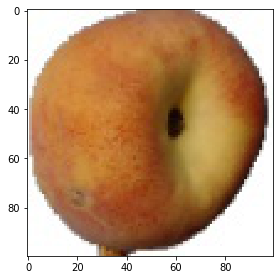

In [6]:
#test data access

import numpy as np
from skimage import io

def get_train_fruit(name, num=1):
  return io.imread(f"fruit-dataset/train/train/{name}_{num}.jpg")

def get_test_fruit(num=1):
  return io.imread(f"fruit-dataset/test/test/{str(num).zfill(4)}.jpg")

im_cv = get_train_fruit("Peach",2)

io.imshow(im_cv)

In [7]:
#@title Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import datetime
import pandas as pd
import seaborn as sns
import subprocess
import os
import re

In [49]:
#Process Dataset

class FruitsDataset(Dataset):
  def __init__(self, file_path, transforms=None):
    self.file_path = file_path
    self.transforms = transforms

    contents = os.listdir(self.file_path)

    #filter jpgs
    def jpg_filter(string, eq=True):
      if len(string) < 5:
        return False or not eq
      
      if eq:
        return string[-4:] == ".jpg"
      else:
        return string[-4:] != ".jpg"

    #get all images
    self.files = list(filter(jpg_filter, contents))
    
    #get all labels
    self.label_names = sorted(list(filter(lambda x: jpg_filter(x, False), contents)))
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    img = io.imread(f"{self.file_path}/{self.files[index]}")

    #extract fruit name: fruit_num.jpg
    label = self.files[index].split("_")[0]
    label = torch.tensor(self.label_names.index(label))

    if self.transforms:
      img = self.transforms(img)


    return (img, label)

In [50]:
df = FruitsDataset("fruit-dataset/train/train", transforms=
                                                transforms.Compose([
                                                                    transforms.ToTensor(),
                                                                    transforms.Resize((64, 64))
                                                ]))

In [51]:
#image size
print(df[0][0].shape)

#image label
print(f"{df[0][1]} => {df.label_names[df[0][1]]}")

#total labels & label names
print(f"{len(df.label_names)}, label names={df.label_names}")

torch.Size([3, 64, 64])
6 => Cactus fruit
33, label names=['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


In [57]:
#Fruit Model
import torch.nn.functional as F

#[3C x 64 x 64] -> conv2d[16 x 64 x 64] -> tanh -> maxpool2d[16 x 32 x 32] -> conv2d[8 x 32 x 32] -> tanh -> maxpool2d[8 x 16 x 16]
#flatten[8*16*16] -> lin[64] -> tanh -> lin[33]

#input is 3C x 64 x 64
#output is 33, based on total img labels

class FruitNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8*16*16, 64)
    self.fc2 = nn.Linear(64, 33)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = torch.flatten(out)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)

    return out

In [68]:
model = FruitNet()

model

FruitNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=33, bias=True)
)

In [66]:
#test image passing
F.softmax(model(df[0][0]), dim=0)

tensor([0.0282, 0.0294, 0.0321, 0.0298, 0.0354, 0.0295, 0.0295, 0.0289, 0.0314,
        0.0266, 0.0296, 0.0289, 0.0334, 0.0345, 0.0283, 0.0364, 0.0347, 0.0294,
        0.0275, 0.0284, 0.0351, 0.0356, 0.0293, 0.0328, 0.0263, 0.0296, 0.0276,
        0.0293, 0.0305, 0.0294, 0.0245, 0.0294, 0.0286],
       grad_fn=<SoftmaxBackward0>)

In [1]:
#change runtime type to GPU
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

NameError: ignored